In [2]:
from astropy.io import fits
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb, SqrtStretch,ZScaleInterval
import numpy as np
from matplotlib.patches import Rectangle


In [3]:
# set path for training data
morphology_path = 'E:/galaxyzoo_morph/train/'

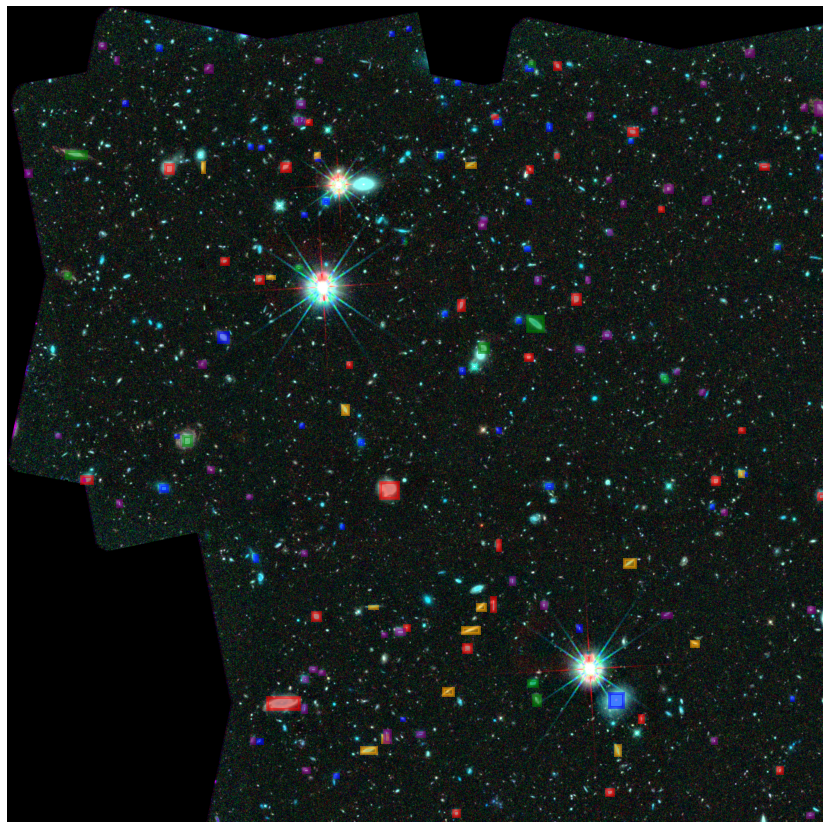

In [5]:
# make a list of all the training data image files
image_files = glob.glob(morphology_path+'*.fits')



# find the first image in the list to display etc
first_image = image_files[0]

# read the fits data where frame 0 is the F606W data, frame 1 is the F775W or F814W data depending on field, frame 2 is the F125W data
# and frame 3 is the F160W data
# here we read the F606W, F125W, and F160W data because all the fields have data in these wavelengths
image1 = fits.open(first_image)
data_f606 = image1[0].data
data_f125 = image1[2].data
data_f160 = image1[3].data

# find the file of labels associated with the first image, use the base name from the image and add on the suffix for the label file
# and read those labels into a dataframe
label_file = first_image.split('.')[0]+'_sources.json'
labels = pd.read_json(label_file)


# split the labels dataframe into dataframes for each unique label type for the sake of plotting
ellipticals = labels[labels.obj_type == 'elliptical'].copy()
spirals = labels[labels.obj_type == 'spiral'].copy()
edgeon = labels[labels.obj_type == 'edge-on'].copy()
irregulars = labels[labels.obj_type == 'irregular'].copy()
barredspirals = labels[labels.obj_type == 'barred-spiral'].copy()



# set an image stretch to use for displaying the images
stretch = SqrtStretch()+ZScaleInterval()

# stretch all the image data
data_f606 = stretch(data_f606)
data_f125 = stretch(data_f125)
data_f160 = stretch(data_f160)

# find the upper and lower limits of the imaging data to use to set the three color image stretch
low_value, high_value = np.percentile(np.hstack((data_f606.flatten(), data_f125.flatten(), data_f160.flatten())), (0.5, 99.5))
stretch_value = high_value - low_value



# creates a three color image based on the article by Lupton et al: https://arxiv.org/pdf/astro-ph/0312483.pdf
# this uses an asinh stretch with a softening parameter Q. The default values are such that stretch (or the range between minimum and maximum values) is equal to 5,
# and Q = 8.
three_color = make_lupton_rgb(data_f606, data_f125, data_f160, stretch=high_value, Q=0, minimum=low_value)



# display the three color image with matplotlib
# and turn off the axes because they're just annoying
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(three_color)
ax.axis('off')


# overplot the labeled galaxies in the frame with a different color for each label type
# the Rectangle patch in matplotlib uses the lower left corner position followed by the width and height in pixels
# this is similar to what is used to define bounding boxes for YOLO based models, except that YOLO requires positions to be
# normalized by image size
# Elliptical galaxy bounding boxes are in blue, spiral galaxy bounding boxes are in red, edge-on galaxies are in orange, 
# barred spirals are in green and irregular galaxies are in purple

for index,row in ellipticals.iterrows():
    ax.add_patch(Rectangle((row.bbox_min_col, row.bbox_min_row), row.bbox_width, row.bbox_height, color='b', alpha=0.5, ec='b', lw=3))

for index,row in spirals.iterrows():
    ax.add_patch(Rectangle((row.bbox_min_col, row.bbox_min_row), row.bbox_width, row.bbox_height, color='r', alpha=0.5, ec='r', lw=3))

for index,row in edgeon.iterrows():
    ax.add_patch(Rectangle((row.bbox_min_col, row.bbox_min_row), row.bbox_width, row.bbox_height, color='orange', alpha=0.5, ec='orange', lw=3))

for index,row in barredspirals.iterrows():
        ax.add_patch(Rectangle((row.bbox_min_col, row.bbox_min_row), row.bbox_width, row.bbox_height, color='green', alpha=0.5, ec='green', lw=3))

for index,row in irregulars.iterrows():
        ax.add_patch(Rectangle((row.bbox_min_col, row.bbox_min_row), row.bbox_width, row.bbox_height, color='purple', alpha=0.5, ec='purple', lw=3))


plt.show()
